In [1]:
#importing all required packages
from sklearn.tree import export_text
from sklearn.datasets import load_files
from sklearn import preprocessing
from sklearn.utils import shuffle
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV
import numpy as np
import category_encoders as ce
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.tree import DecisionTreeClassifier
import itertools
import timeit
from sklearn.neighbors import KNeighborsClassifier


Setting up the the two datasets

In [13]:
cars = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/car/car.data", header = None)
#Adding the column names
cars_col_names = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']
cars.columns = cars_col_names

import category_encoders as ce
encoder = ce.OrdinalEncoder(cols=['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety'])

cars['class'] = cars['class'].apply(lambda x: 'unacc' if x == 'unacc' else 'acc')

X = cars.drop(['class'], axis=1)


y = cars['class']

print(y.head())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

X_train = encoder.fit_transform(X_train)

X_test = encoder.transform(X_test)

0    unacc
1    unacc
2    unacc
3    unacc
4    unacc
Name: class, dtype: object


Plotting the distribution of the target variable for cars - Class

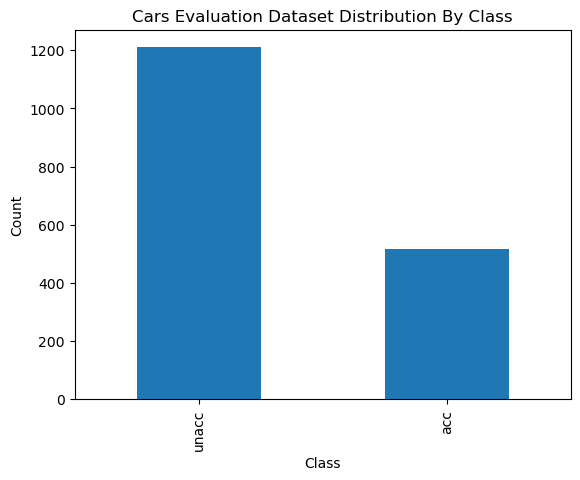

In [3]:
cars["class"].value_counts().plot(kind='bar')
plt.title("Cars Evaluation Dataset Distribution By Class")
plt.xlabel("Class")
plt.ylabel("Count")

# Show the plot
plt.show()

In [14]:
import os
from imblearn.over_sampling import RandomOverSampler

#TODO: Update here
os.chdir(r"D:\\gatech\\cs7641\\supervised_learning")
titanic = pd.read_csv("titanic.csv", header = None)
#Adding the column names
titanic_col_names = ['Age', 'Cabin', 'Embarked', 'Fare', 'Name', 'Parch', 'PassengerId', 'Pclass', 'Sex', 'SibSp', 'Survived', 'Ticket', 'Title','Family_Size']
titanic.columns = titanic_col_names

X2 = titanic.drop(['Survived'], axis=1)
# X2.dropna()

y2 = titanic['Survived']




X2 = pd.get_dummies(X2[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']])   

# X2
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X2, y2, test_size=0.20, random_state=0)


ros = RandomOverSampler(random_state=0)
X_train_2, y_train_2 = ros.fit_resample(X_train_2, y_train_2)


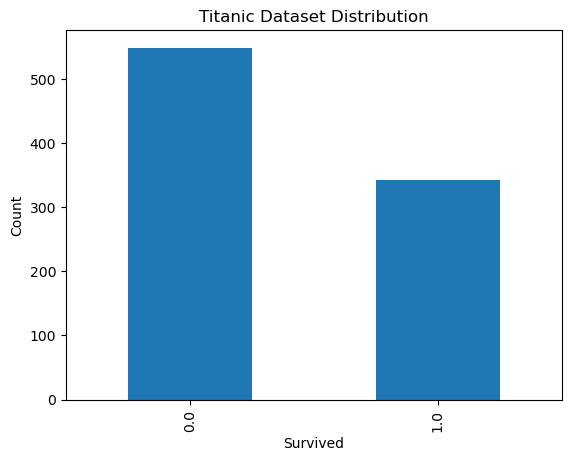

In [5]:
titanic["Survived"].value_counts().plot(kind='bar', x=['Survived', 'No'])
plt.title("Titanic Dataset Distribution")
plt.xlabel("Survived")
plt.ylabel("Count")

# Show the plot
plt.show()

Plotting functions

In [16]:
def plotter(clf, X,y, title):
    train_sizes, train_scores, test_scores = learning_curve(clf, X, y, cv=5, scoring="f1_weighted")

    # Calculate the mean and standard deviation of the training and test scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot the learning curve
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color='g')
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
    plt.legend(loc='best')
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    plt.title(title)
    plt.show()

def plot_v_curve(clf, X,y, title, param_name, param_range):
    train_scores, val_scores = validation_curve(
        clf, X, y, param_name=param_name, param_range=param_range,
        cv=5, scoring='f1_weighted'
    )

    plt.plot(param_range, np.mean(train_scores, axis=1), label='Training Score')
    plt.plot(param_range, np.mean(val_scores, axis=1), label='Validation Score')
    plt.legend(loc='best')
    plt.xlabel(param_name)
    plt.ylabel('F1') 
    plt.title('Validation Curve for '+ title)
    plt.show()

    train_scores, val_scores = validation_curve(
        clf, X, y, param_name=param_name, param_range=param_range,
        cv=5, scoring='accuracy'
    )

    plt.plot(param_range, np.mean(train_scores, axis=1), label='Training Score')
    plt.plot(param_range, np.mean(val_scores, axis=1), label='Validation Score')
    plt.legend(loc='best')
    plt.ylabel('Accuracy') 
    plt.xlabel(param_name)
    plt.title('Validation Curve for '+ title)
    plt.show()

def plot_loss_curve(clf, X, y, title= "Loss curve"):
    clf.fit(X, y)
    c = clf.loss_curve_

    plt.figure()
    plt.title(title)
    plt.xlabel("Number of Iterations")
    plt.ylabel("Loss")
    plt.plot(c, 'o-', color="grey")
    plt.legend(loc="best")
    plt.show()
    # Plot the loss curve



Hyperparameter Tuning

In [17]:
def tune_parameters(clf, param_grid, X, y, title):
    grid_search = GridSearchCV(clf, param_grid, cv=5)
    grid_search.fit(X, y)

    
    print("Best hyperparameters:", grid_search.best_params_)
    print("Best accuracy:", grid_search.best_score_)
    # Get the mean test score for each combination of hyperparameters
    mean_test_scores = grid_search.cv_results_['mean_test_score']

    # Get the parameters for each combination of hyperparameters
    params = grid_search.cv_results_['params']

    # Loop over the mean test scores and parameters and print them
    # print('Hyperparameter Tuning Values for - ' + title)
    # for mean_test_score, param in zip(mean_test_scores, params):
    #     print("Mean Test Score: {:.3f} with Parameters: {}".format(mean_test_score, param))

    return clf

Decision tree Cars

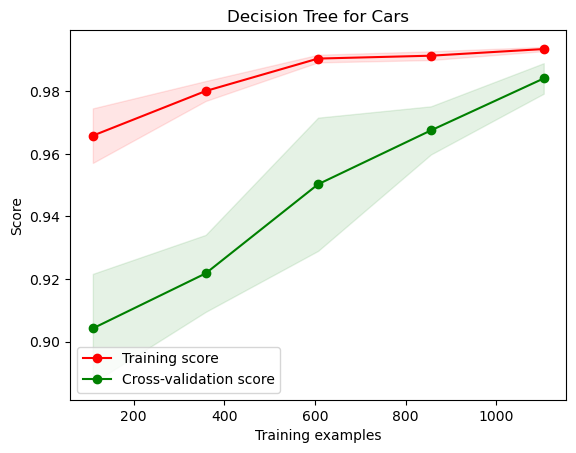

In [14]:

param_grid = {
    "max_depth": [2,3,4,5,6,7,8,9,10,11,12,13,14,15],
    "min_samples_split": [2,3,4,5,6,7,8,9,10,11,12,13,14,15],
    "min_samples_leaf": [2,3,4,5,6,7,8,9,10,11,12,13,14,15],
    "criterion": ["gini", "entropy"],
}

# TODO: uncomment the following line for hyperparameter tuning
# plot_v_curve(DecisionTreeClassifier(), X_train, y_train, 'Decision Tree - Cars Dataset', 'max_depth', [2,3,4,5,6,7,8,9,10,11,12,13,14,15])
# plot_v_curve(DecisionTreeClassifier(), X_train, y_train, 'Decision Tree - Cars Dataset', 'min_samples_split',[2,3,4,5,6,7,8,9,10,11,12,13,14,15])
# plot_v_curve(DecisionTreeClassifier(), X_train, y_train, 'Decision Tree - Cars Dataset', 'min_samples_leaf', [2,3,4,5,6,7,8,9,10,11,12,13,14,15])

# dt_cars_classifier = tune_parameters(DecisionTreeClassifier(), param_grid, X_train, y_train, 'Decision Trees with Cars')

dt_cars_classifier = DecisionTreeClassifier(criterion='entropy', max_depth= 13, min_samples_leaf= 2, min_samples_split= 4)

final_tuned_params = {'criterion': 'entropy', 'max_depth': 13, 'min_samples_leaf': 2, 'min_samples_split': 4}
plotter(dt_cars_classifier, X_train, y_train, 'Decision Tree for Cars')


Actual Classification with the decision tree

In [17]:
dt_cars_classifier.fit(X_train, y_train)
predictions = dt_cars_classifier.predict(X_test)

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, predictions)

print('Confusion matrix\n\n', cm)

from sklearn.metrics import classification_report
print('Class Report')
print(classification_report(y_test, predictions))

from sklearn.metrics import accuracy_score, f1_score

print('F1 Score:')
print(f1_score(y_test, predictions, average='weighted'))


print('Accuracy:')
accuracy_score(y_test, predictions)


Confusion matrix

 [[108   3]
 [  1 234]]
Class Report
              precision    recall  f1-score   support

         acc       0.99      0.97      0.98       111
       unacc       0.99      1.00      0.99       235

    accuracy                           0.99       346
   macro avg       0.99      0.98      0.99       346
weighted avg       0.99      0.99      0.99       346

F1 Score:
0.9884112507459231
Accuracy:


0.9884393063583815

Decision Tree Titanic

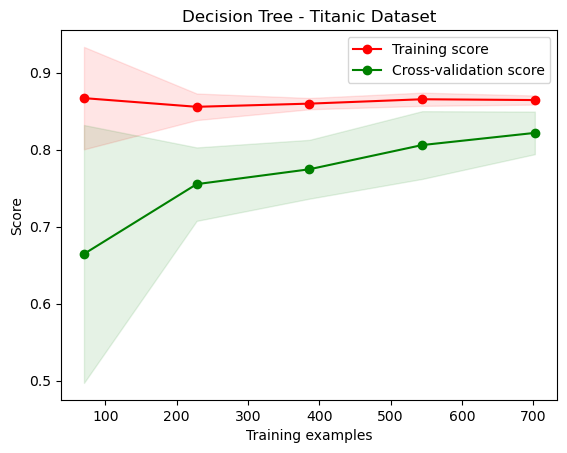

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier


param_grid = {
    "max_depth": [2,3,4,5,6,7,8,9,10,11,12,13,14,15],
    "min_samples_split": [2,3,4,5,6,7,8,9,10],
    "min_samples_leaf": [2,3,4,5,6,7,8,9,10],
}

# TODO: uncomment the following line for hyperparameter tuning
# plot_v_curve(DecisionTreeClassifier(), X_train_2.values, y_train_2, 'Decision Trees - Titanic Dataset', 'max_depth', [2,3,4,5,6,7,8,9,10,11,12,13,14,15])
# plot_v_curve(DecisionTreeClassifier(), X_train_2.values, y_train_2, 'Decision Trees - Titanic Dataset', 'min_samples_split',[2,3,4,5,6,7,8,9,10,11,12,13,14,15])
# plot_v_curve(DecisionTreeClassifier(), X_train_2.values, y_train_2, 'Decision Trees - Titanic Dataset', 'min_samples_leaf', [2,3,4,5,6,7,8,9,10,11,12,13,14,15])

# dt_titanic_classifier = tune_parameters(DecisionTreeClassifier(), param_grid, X_train_2.values, y_train_2, 'Decision Trees - Titanic Dataset')

final_tuned_params_dt_titanic = {'max_depth': 12, 'min_samples_leaf': 7, 'min_samples_split': 3}

dt_titanic_classifier = DecisionTreeClassifier(max_depth= 12, min_samples_leaf= 7, min_samples_split= 3)

plotter(dt_titanic_classifier, X_train_2.values, y_train_2, 'Decision Tree - Titanic Dataset')



In [20]:
dt_titanic_classifier.fit(X_train_2.values, y_train_2)
predictions_dt_titanic = dt_titanic_classifier.predict(X_test_2.values)

cm = confusion_matrix(y_test_2, predictions_dt_titanic)

print('Confusion matrix\n\n', cm)

print('Class Report')
print(classification_report(y_test_2, predictions_dt_titanic))

print('F1 Score:')
print(f1_score(y_test_2, predictions_dt_titanic, average='weighted'))


print('Accuracy:')
accuracy_score(y_test_2, predictions_dt_titanic)

Confusion matrix

 [[96 14]
 [21 48]]
Class Report
              precision    recall  f1-score   support

         0.0       0.82      0.87      0.85       110
         1.0       0.77      0.70      0.73        69

    accuracy                           0.80       179
   macro avg       0.80      0.78      0.79       179
weighted avg       0.80      0.80      0.80       179

F1 Score:
0.8022599613032163
Accuracy:


0.8044692737430168

Neural Nets Cars

d:\miniconda3\envs\ai_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
d:\miniconda3\envs\ai_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
d:\miniconda3\envs\ai_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
d:\miniconda3\envs\ai_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
d:\miniconda3\envs\ai_env\lib\site-packages\

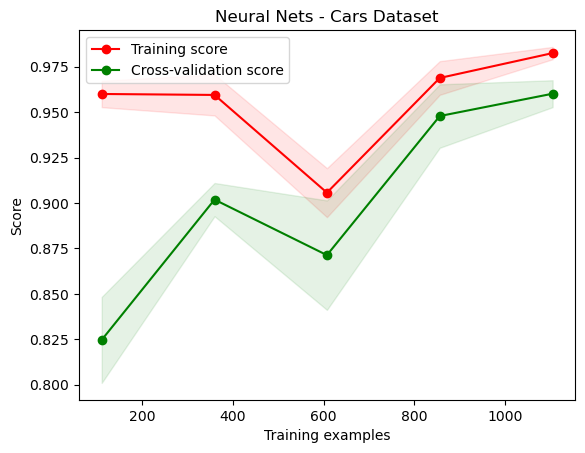

In [22]:
param_grid = {
    'hidden_layer_sizes': [(10,), (20,), (30,), (40,), (50,), (60,)],
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
}

# TODO: uncomment the following line for hyperparameter tuning
# plot_loss_curve(MLPClassifier(max_iter=1000), X_train, y_train, 'Neural Nets - Cars Dataset')

# plot_v_curve(MLPClassifier(max_iter=1000), X_train, y_train, 'Neural Nets - Cars Dataset', 'hidden_layer_sizes', [(10,), (20,), (30,), (40,), (50,), (60,)])
# plot_v_curve(MLPClassifier(max_iter=500), X_train, y_train, 'Neural Nets - Cars Dataset', 'alpha', [0.0001, 0.001, 0.01, 0.1, 1, 10, 100])

# nn_cars_classifier = tune_parameters(MLPClassifier(max_iter=1000), param_grid, X_train, y_train, 'Neural Nets - Cars Dataset')

final_tuned_params = {'alpha': 0.0001, 'hidden_layer_sizes': (50,)}

nn_cars_classifier = MLPClassifier(max_iter=1000, hidden_layer_sizes=(50,), alpha=0.0001)

plotter(nn_cars_classifier, X_train, y_train, 'Neural Nets - Cars Dataset')

Actual classification with Neural Nets - Cars

In [23]:
nn_cars_classifier.fit(X_train, y_train)
nn_cars_predictions = nn_cars_classifier.predict(X_test)

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, nn_cars_predictions)

print('Confusion matrix\n\n', cm)

from sklearn.metrics import classification_report
print('Class Report')
print(classification_report(y_test, nn_cars_predictions))

from sklearn.metrics import accuracy_score, f1_score

print('F1 Score:')
print(f1_score(y_test, nn_cars_predictions, average='weighted'))


print('Accuracy:')
accuracy_score(y_test, nn_cars_predictions)

Confusion matrix

 [[108   3]
 [  5 230]]
Class Report
              precision    recall  f1-score   support

         acc       0.96      0.97      0.96       111
       unacc       0.99      0.98      0.98       235

    accuracy                           0.98       346
   macro avg       0.97      0.98      0.97       346
weighted avg       0.98      0.98      0.98       346

F1 Score:
0.9769324285220241
Accuracy:


d:\miniconda3\envs\ai_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


0.976878612716763

Neural Nets Titanic

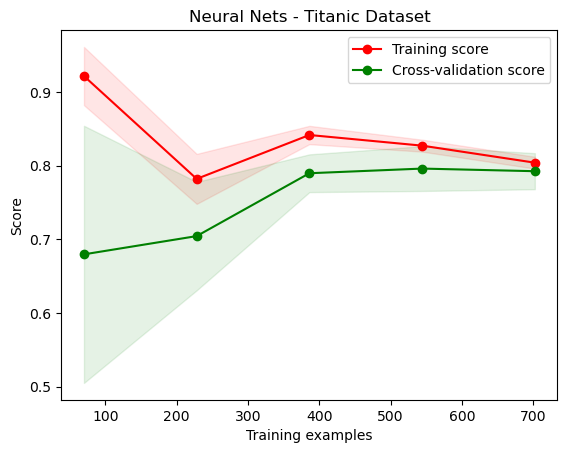

In [8]:

param_grid = {
    'hidden_layer_sizes': [(10,), (20,), (30,), (40,), (50,), (60,)],
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
}

# TODO: uncomment the following line for hyperparameter tuning
# plot_loss_curve(MLPClassifier(max_iter=1000), X_train_2.values, y_train_2, 'Neural Nets - Titanic Dataset')

# plot_v_curve(MLPClassifier(max_iter=1000), X_train_2.values, y_train_2, 'Neural Nets - Titanic Dataset', 'hidden_layer_sizes', [(10,), (20,), (30,), (40,), (50,), (60,)])
# plot_v_curve(MLPClassifier(max_iter=500), X_train_2.values, y_train_2, 'Neural Nets - Titanic Dataset', 'alpha', [0.0001, 0.001, 0.01, 0.1, 1, 10, 100])

# nn_titanic_classifier = tune_parameters(MLPClassifier(max_iter=1000), param_grid, X_train_2.values, y_train_2, 'Neural Nets - Titanic Dataset')

final_tuned_params = {'alpha': 1, 'hidden_layer_sizes': (60,)}
# Best accuracy: 0.8018701298701298
nn_titanic_classifier = MLPClassifier(max_iter=1000, hidden_layer_sizes=(60,), alpha=1)

plotter(nn_titanic_classifier, X_train_2.values, y_train_2, 'Neural Nets - Titanic Dataset')
# plotter(MLPClassifier(), X_train_2.values, y_train_2, 'Neural Nets')

Actual Classification of Titanic with Neural Nets

In [9]:
nn_titanic_classifier.fit(X_train_2.values, y_train_2)
nn_titanic_predictions = nn_titanic_classifier.predict(X_test_2.values)

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_2, nn_titanic_predictions)

print('Confusion matrix\n\n', cm)

from sklearn.metrics import classification_report
print('Class Report')
print(classification_report(y_test_2, nn_titanic_predictions))

from sklearn.metrics import accuracy_score, f1_score

print('F1 Score:')
print(f1_score(y_test_2, nn_titanic_predictions, average='weighted'))


print('Accuracy:')
accuracy_score(y_test_2, nn_titanic_predictions)

Confusion matrix

 [[93 17]
 [15 54]]
Class Report
              precision    recall  f1-score   support

         0.0       0.86      0.85      0.85       110
         1.0       0.76      0.78      0.77        69

    accuracy                           0.82       179
   macro avg       0.81      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179

F1 Score:
0.8216859354064008
Accuracy:


0.8212290502793296

Boosted DT Cars

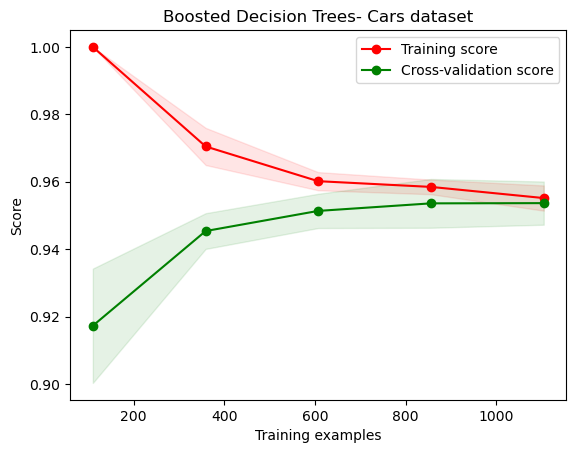

In [13]:
from sklearn.ensemble import AdaBoostClassifier

dt = DecisionTreeClassifier(max_depth = 1)
param_grid = {
    'n_estimators': np.linspace(10,1000,3).round().astype('int'),
    'learning_rate': np.linspace(.001,1,3)
}

# TODO: uncomment the following line for hyperparameter tuning
# plot_v_curve(AdaBoostClassifier(base_estimator=dt), X_train, y_train,'Boosted Trees - Cars Dataset', 'n_estimators', np.linspace(10,1000,3).round().astype('int'))
# plot_v_curve(AdaBoostClassifier(base_estimator=dt), X_train, y_train, 'Boosted Trees - Cars Dataset', 'learning_rate',np.linspace(.001,1,3))

# boosted_dt_cars_classifier = tune_parameters(AdaBoostClassifier(base_estimator=dt), param_grid, X_train, y_train, 'Boosted Decision Trees with Cars')

final_tuned_params_b_dt_cars = {'learning_rate': 0.5005, 'n_estimators': 505}

# Best accuracy: 0.953688588918537
boosted_dt_cars_classifier = AdaBoostClassifier(base_estimator=dt, learning_rate= 0.5005, n_estimators= 505)
plotter(boosted_dt_cars_classifier, X_train, y_train, 'Boosted Decision Trees- Cars dataset')

Actual Classification-Boosted DT -Cars

In [14]:
boosted_dt_cars_classifier.fit(X_train, y_train)
predictions_boosted_dt_cars = boosted_dt_cars_classifier.predict(X_test)

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, predictions_boosted_dt_cars)

print('Confusion matrix\n\n', cm)

from sklearn.metrics import classification_report
print('Class Report')
print(classification_report(y_test, predictions_boosted_dt_cars))

from sklearn.metrics import accuracy_score, f1_score

print('F1 Score:')
print(f1_score(y_test, predictions_boosted_dt_cars, average='weighted'))


print('Accuracy:')
accuracy_score(y_test, predictions_boosted_dt_cars)


Confusion matrix

 [[100  11]
 [  7 228]]
Class Report
              precision    recall  f1-score   support

         acc       0.93      0.90      0.92       111
       unacc       0.95      0.97      0.96       235

    accuracy                           0.95       346
   macro avg       0.94      0.94      0.94       346
weighted avg       0.95      0.95      0.95       346

F1 Score:
0.9477191091110106
Accuracy:


0.9479768786127167

Boosted DT Titanic

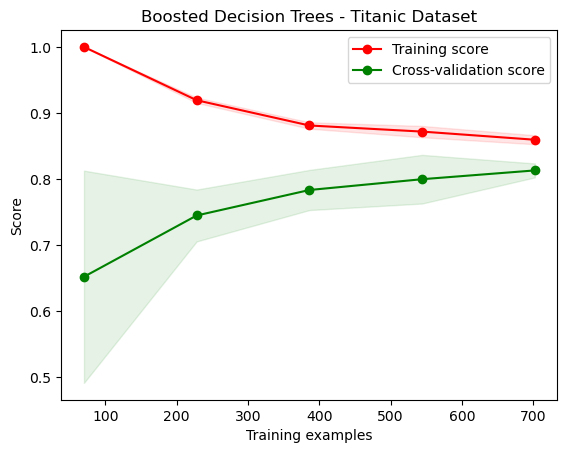

In [16]:
dt = DecisionTreeClassifier(max_depth = 1)
param_grid = {
    'n_estimators': np.linspace(10,1000,3).round().astype('int'),
    'learning_rate': np.linspace(.001,1,3)
}

# TODO: uncomment the following line for hyperparameter tuning
# plot_v_curve(AdaBoostClassifier(base_estimator=dt), X_train_2.values, y_train_2,'Boosted Trees - Titanic Dataset', 'n_estimators', np.linspace(10,1000,3).round().astype('int'))
# plot_v_curve(AdaBoostClassifier(base_estimator=dt), X_train_2.values, y_train_2, 'Boosted Trees - Titanic Dataset', 'learning_rate',np.linspace(.001,1,3))

# boosted_dt_titanic_classifier = tune_parameters(AdaBoostClassifier(base_estimator=dt), param_grid, X_train_2.values, y_train_2, 'Boosted Decision Trees with Titanic')

final_tuned_params_b_dt_titanic = {'learning_rate': 0.5005, 'n_estimators': 505}

# Best accuracy: 0.8132337662337662
boosted_dt_titanic_classifier = AdaBoostClassifier(base_estimator=dt, learning_rate=0.5005, n_estimators=505)

plotter(boosted_dt_titanic_classifier, X_train_2.values, y_train_2, 'Boosted Decision Trees - Titanic Dataset')


Actual Classification of Boosted DT -Titanic Dataset

In [17]:
boosted_dt_titanic_classifier.fit(X_train_2.values, y_train_2)
boosted_dt_titanic_predictions = boosted_dt_titanic_classifier.predict(X_test_2.values)

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_2, boosted_dt_titanic_predictions)

print('Confusion matrix\n\n', cm)

from sklearn.metrics import classification_report
print('Class Report')
print(classification_report(y_test_2, boosted_dt_titanic_predictions))

from sklearn.metrics import accuracy_score, f1_score

print('F1 Score:')
print(f1_score(y_test_2, boosted_dt_titanic_predictions, average='weighted'))


print('Accuracy:')
accuracy_score(y_test_2, boosted_dt_titanic_predictions)

Confusion matrix

 [[93 17]
 [14 55]]
Class Report
              precision    recall  f1-score   support

         0.0       0.87      0.85      0.86       110
         1.0       0.76      0.80      0.78        69

    accuracy                           0.83       179
   macro avg       0.82      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179

F1 Score:
0.8274609023450102
Accuracy:


0.8268156424581006

SVM Cars

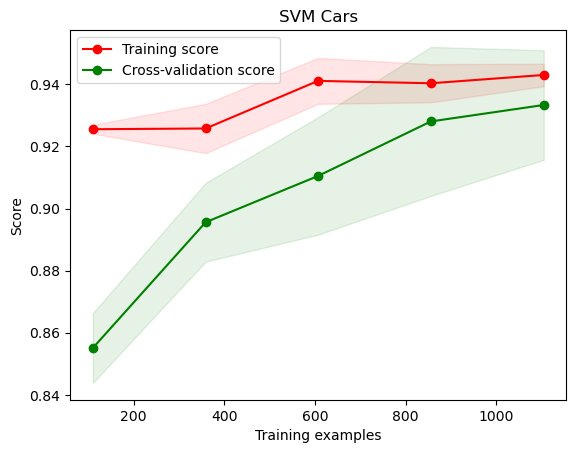

In [38]:
from sklearn.svm import SVC
# param_grid = {'C': [0.1, 1, 10, 100, 1000], 'tol': [0.0001, 0.001, 0.01, 0.1, 1]}

# param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['sigmoid']}

C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
# TODO: uncomment the following line for hyperparameter tuning

# plot_v_curve(SVC(kernel="poly"), X_train, y_train, 'SVM - Cars Dataset - Poly', 'degree', [1,2,3,4])
# plot_v_curve(SVC(kernel="poly"), X_train, y_train, 'SVM - Cars Dataset - Poly', 'C', [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.6,0.8, 1, 5,10, 15, 20])

# plot_v_curve(SVC(kernel="rbf"), X_train, y_train, 'SVM - Cars Dataset - rbf', 'C', C_range)
# plot_v_curve(SVC(kernel="rbf"), X_train, y_train, 'SVM - Cars Dataset - rbf', 'gamma', gamma_range)

# plot_v_curve(MLPClassifier(max_iter=500), X_train, y_train, 'Neural Nets - Cars Dataset', 'alpha', [0.0001, 0.001, 0.01, 0.1, 1, 10, 100])


# optimal_clf = tune_parameters(SVC(kernel="rbf"), {'C': C_range, 'gamma': gamma_range}, X_train, y_train, 'SVC RBF kernel - Cars Dataset')

# The best parameters are {'C': 1.0, 'gamma': 0.09999999999999999} with a score of 0.97


svm_rbf_cars_classifier = SVC(kernel="rbf", C=1.0, gamma=0.09999999999999999)
plotter(svm_rbf_cars_classifier, X_train, y_train, 'SVM Cars')






Actual Classification with SVM RBF -Cars

In [36]:
svm_rbf_cars_classifier.fit(X_train, y_train)
predictions_svm_cars = svm_rbf_cars_classifier.predict(X_test)

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, predictions_svm_cars)

print('Confusion matrix\n\n', cm)

from sklearn.metrics import classification_report
print('Class Report')
print(classification_report(y_test, predictions_svm_cars))

from sklearn.metrics import accuracy_score, f1_score

print('F1 Score:')
print(f1_score(y_test, predictions_svm_cars, average='weighted'))


print('Accuracy:')
accuracy_score(y_test, predictions_svm_cars)


Confusion matrix

 [[101  10]
 [  5 230]]
Class Report
              precision    recall  f1-score   support

         acc       0.95      0.91      0.93       111
       unacc       0.96      0.98      0.97       235

    accuracy                           0.96       346
   macro avg       0.96      0.94      0.95       346
weighted avg       0.96      0.96      0.96       346

F1 Score:
0.9563761164985931
Accuracy:


0.9566473988439307

SVM titanic dataset

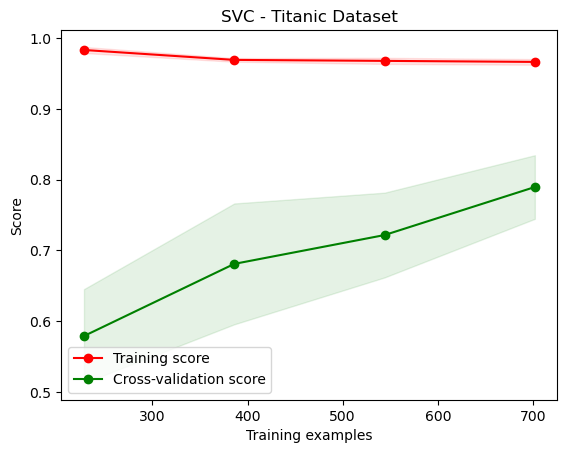

In [49]:
from sklearn.svm import SVC
# plotter(SVC(kernel="poly"), X_train_2.values, y_train_2, 'SVM Titanic')
# plotter(SVC(kernel="rbf"), X_train_2.values, y_train_2, 'SVM Titanic')
# plotter(SVC(kernel="sigmoid"), X_train_2.values, y_train_2, 'SVM Titanic')



# param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['sigmoid']}

# optimal_clf = tune_parameters(SVC(), param_grid, X_train_2.values, y_train_2, 'SVC Sigmoid kernel - Cars Dataset')


# plotter(SVC(kernel="sigmoid"), X_train_2.values, y_train_2, 'SVC Sigmoid kernel - Cars Dataset')
# plotter(optimal_clf, X_train_2.values, y_train_2, 'SVC Sigmoid kernel - Cars Dataset')
# plotter(SVC(kernel="poly"), X_train_2.values, y_train_2, 'SVM Cars')
# plotter(SVC(kernel="rbf"), X_train_2.values, y_train_2, 'SVM Cars')

##################################################################################

# param_grid = {
#               'C': [0.1, 1, 10, 100],
#               'degree': [2, 3, 4],
#               'gamma': ['scale', 'auto'],
#               'coef0': [0, 1],
#               'kernel': ['poly']}

# # optimal_clf = tune_parameters(SVC(), param_grid, X_train_2.values, y_train_2, 'SVC Poly kernel - Cars Dataset')


# plotter(SVC(kernel="poly"), X_train_2.values, y_train_2, 'SVC Poly kernel - Cars Dataset')
# plotter(optimal_clf, X_train_2.values, y_train_2, 'SVC Poly kernel - Cars Dataset')
Best_hyperparameters ={'C': 1000.0, 'gamma': 0.1}
# Best accuracy: 0.9942081305917438
svm_titanic_classifier = SVC(kernel="rbf", C=1000.0, gamma=0.1)
plotter(svm_titanic_classifier, X_train_2.values, y_train_2, 'SVC - Titanic Dataset')



In [50]:
#classification
svm_titanic_classifier.fit(X_train_2.values, y_train_2)
predictions_svm_titanic = svm_titanic_classifier.predict(X_test_2.values)

cm = confusion_matrix(y_test_2, predictions_svm_titanic)

print('Confusion matrix\n\n', cm)

print('Class Report')
print(classification_report(y_test_2, predictions_svm_titanic))

print('F1 Score:')
print(f1_score(y_test_2, predictions_svm_titanic, average='weighted'))


print('Accuracy:')
accuracy_score(y_test_2, predictions_svm_titanic)

Confusion matrix

 [[86 24]
 [33 36]]
Class Report
              precision    recall  f1-score   support

         0.0       0.72      0.78      0.75       110
         1.0       0.60      0.52      0.56        69

    accuracy                           0.68       179
   macro avg       0.66      0.65      0.65       179
weighted avg       0.68      0.68      0.68       179

F1 Score:
0.6767134929788898
Accuracy:


0.6815642458100558

KNN- Cars

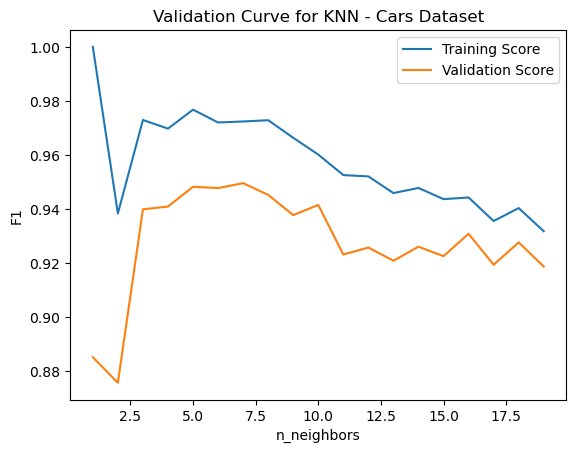

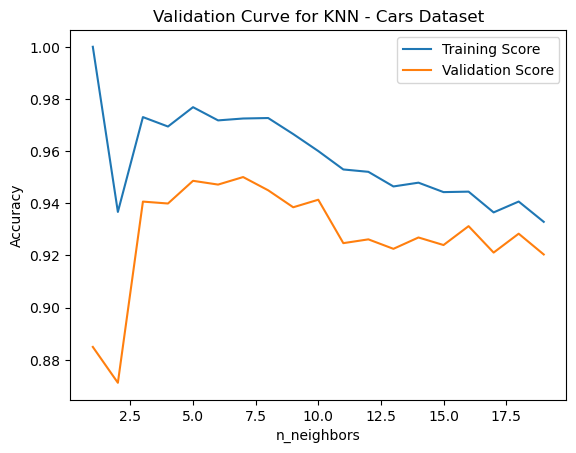

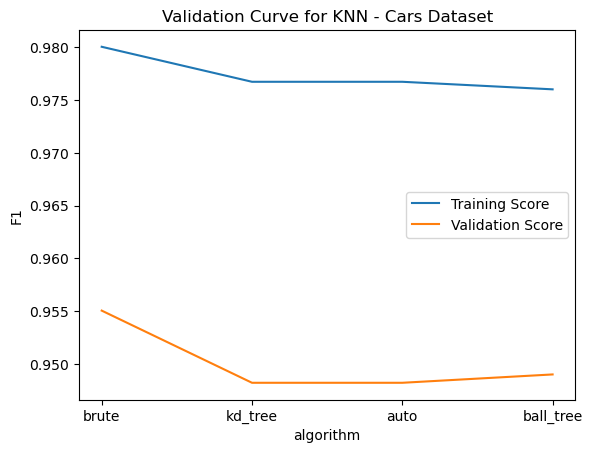

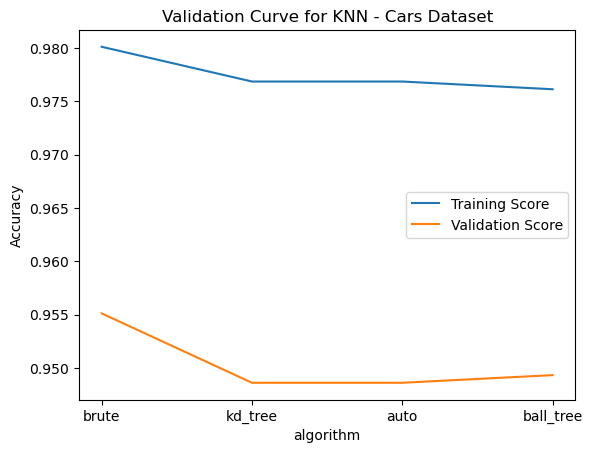

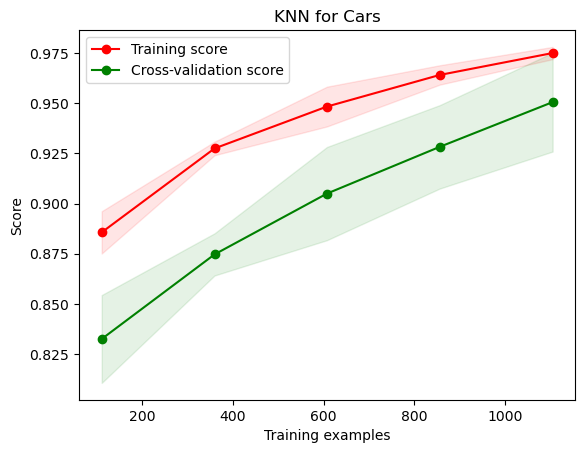

In [31]:
param_grid = {'n_neighbors': np.arange(1, 50),
              'algorithm':['brute', 'kd_tree', 'auto', 'ball_tree']}

# TODO: uncomment the following line for hyperparameter tuning
plot_v_curve(KNeighborsClassifier(), X_train, y_train, 'KNN - Cars Dataset', 'n_neighbors', np.arange(1, 20))
plot_v_curve(KNeighborsClassifier(), X_train, y_train, 'KNN - Cars Dataset', 'algorithm',['brute', 'kd_tree', 'auto', 'ball_tree'])


# knn_cars_classifier = tune_parameters(KNeighborsClassifier(), param_grid, X_train, y_train, 'KNN with Cars')

# Best_hyperparameters= {'n_neighbors': 7, 'algorithm': 'brute'}
# # Best accuracy: 0.9551274001988176

knn_cars_classifier = KNeighborsClassifier(n_neighbors=7, algorithm='brute')

plotter(knn_cars_classifier, X_train, y_train, 'KNN for Cars')

Actual Classification with KNN - Cars Dataset

In [30]:
knn_cars_classifier.fit(X_train, y_train)
predictions_knn_cars = knn_cars_classifier.predict(X_test)

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, predictions_knn_cars)

print('Confusion matrix\n\n', cm)

from sklearn.metrics import classification_report
print('Class Report')
print(classification_report(y_test, predictions_knn_cars))

from sklearn.metrics import accuracy_score, f1_score

print('F1 Score:')
print(f1_score(y_test, predictions_knn_cars, average='weighted'))


print('Accuracy:')
accuracy_score(y_test, predictions_knn_cars)

Confusion matrix

 [[ 97  14]
 [  1 234]]
Class Report
              precision    recall  f1-score   support

         acc       0.99      0.87      0.93       111
       unacc       0.94      1.00      0.97       235

    accuracy                           0.96       346
   macro avg       0.97      0.93      0.95       346
weighted avg       0.96      0.96      0.96       346

F1 Score:
0.9558825323034791
Accuracy:


0.9566473988439307

KNN-Titanic

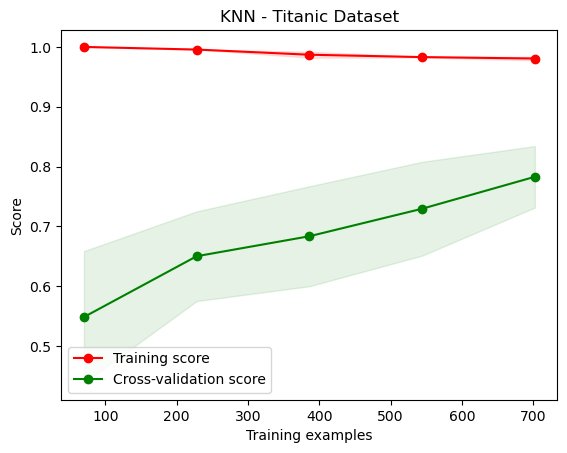

In [45]:
param_grid = {'n_neighbors': np.arange(1, 20),
              'weights': ['uniform', 'distance']}

# TODO: uncomment the following line for hyperparameter tuning
# plot_v_curve(KNeighborsClassifier(), X_train_2.values, y_train_2, 'KNN - Titanic Dataset', 'n_neighbors', np.arange(1, 20))
# plot_v_curve(KNeighborsClassifier(), X_train_2.values, y_train_2, 'KNN - Titanic Dataset', 'algorithm',['brute', 'kd_tree', 'auto', 'ball_tree'])
# plot_v_curve(KNeighborsClassifier(), X_train_2.values, y_train_2, 'KNN - Titanic Dataset', 'weights',['uniform', 'distance'])

# knn_titanic_classifier = tune_parameters(KNeighborsClassifier(), param_grid, X_train_2.values, y_train_2, 'KNN with Titanic')


# plotter(knn_titanic_classifier, X_train_2.values, y_train_2.values, 'Knn -Titanic Dataset')

Best_hyperparameters= {'n_neighbors': 12, 'weights': 'distance'}
# Best accuracy: 0.7837077922077922


knn_titanic_classifier = KNeighborsClassifier(n_neighbors=12, weights='distance')
plotter(knn_titanic_classifier, X_train_2.values, y_train_2, 'KNN - Titanic Dataset')



Actual Classification with KNN -Titanic

In [46]:
knn_titanic_classifier.fit(X_train_2.values, y_train_2)
predictions_knn_titanic = knn_titanic_classifier.predict(X_test_2.values)

cm = confusion_matrix(y_test_2, predictions_knn_titanic)

print('Confusion matrix\n\n', cm)

print('Class Report')
print(classification_report(y_test_2, predictions_knn_titanic))

print('F1 Score:')
print(f1_score(y_test_2, predictions_knn_titanic, average='weighted'))


print('Accuracy:')
accuracy_score(y_test_2, predictions_knn_titanic)

Confusion matrix

 [[88 22]
 [19 50]]
Class Report
              precision    recall  f1-score   support

         0.0       0.82      0.80      0.81       110
         1.0       0.69      0.72      0.71        69

    accuracy                           0.77       179
   macro avg       0.76      0.76      0.76       179
weighted avg       0.77      0.77      0.77       179

F1 Score:
0.7718031289079169
Accuracy:


0.770949720670391

Final Classification